### Machine Learning Model Explanation

The machine learning model used for predicting the number of districts won by party 0 (normalized by K).

#### Neural Network Model

The neural network consists of an input layer, two hidden layers, and an output layer. The network uses the ReLU activation function for the hidden layers and no activation function for the output layer.

#### Mathematical Formulation

1. **Input Layer**:
   - Let **x** ∈ ℝⁿ be the input feature vector, where *n = 24* (the number of input features).

2. **First Hidden Layer**:
   - **Weights**: **W₁** ∈ ℝ⁶⁴ˣ²⁴
   - **Biases**: **b₁** ∈ ℝ⁶⁴
   - **Activation**: ReLU
   - **Output**: 
     $$ \mathbf{h}_1 = \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) $$

3. **Second Hidden Layer**:
   - **Weights**: **W₂** ∈ ℝ³²ˣ⁶⁴
   - **Biases**: **b₂** ∈ ℝ³²
   - **Activation**: ReLU
   - **Output**: 
     $$ \mathbf{h}_2 = \text{ReLU}(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2) $$

4. **Output Layer**:
   - **Weights**: **W₃** ∈ ℝ¹ˣ³²
   - **Biases**: **b₃** ∈ ℝ¹
   - **No Activation**
   - **Output**: 
     $$ \hat{y} = \mathbf{W}_3 \mathbf{h}_2 + \mathbf{b}_3 $$

#### Activation Function

- **ReLU (Rectified Linear Unit)**:
  $$ \text{ReLU}(z) = \max(0, z) $$

#### Loss Function

The loss function used is Mean Squared Error (MSE), given by:

$$ \mathcal{L}(y, \hat{y}) = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 $$

where *yᵢ* is the true normalized number of districts won, *\hat{y}ᵢ* is the predicted value, and *m* is the number of samples.

#### Optimization

The weights and biases of the neural network are optimized using the Adam optimizer, which updates the parameters based on the gradients of the loss function.

#### Accuracy Metric

The accuracy is calculated as:

$$ \text{Accuracy} = 1 - \frac{1}{m} \sum_{i=1}^{m} \frac{|y_i - \hat{y}_i|}{K} $$

where *K* is the maximum number of districts.

#### Summary of the Formulas

1. **First Hidden Layer**:
   $$ \mathbf{h}_1 = \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) $$

2. **Second Hidden Layer**:
   $$ \mathbf{h}_2 = \text{ReLU}(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2) $$

3. **Output Layer**:
   $$ \hat{y} = \mathbf{W}_3 \mathbf{h}_2 + \mathbf{b}_3 $$

4. **Loss Function**:
   $$ \mathcal{L}(y, \hat{y}) = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 $$

5. **Accuracy Metric**:
   $$ \text{Accuracy} = 1 - \frac{1}{m} \sum_{i=1}^{m} \frac{|y_i - \hat{y}_i|}{K} $$

Epoch [10/10], Loss: 0.0146, Accuracy: 0.9916


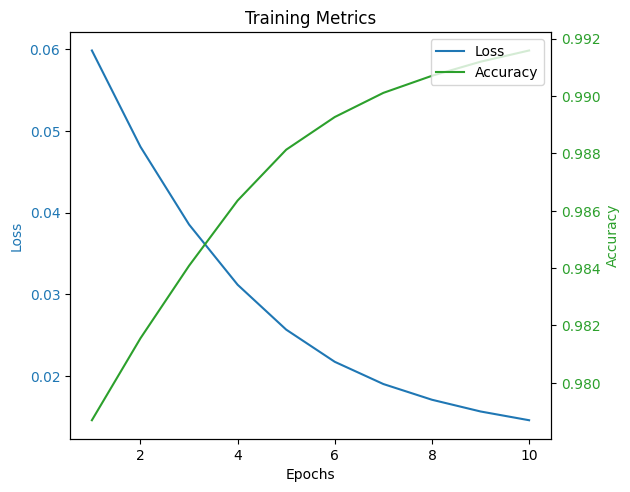

Accuracy: 0.9916


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv('../simulation_data.csv')

# Features and target variable
features = data[['votes_0', 'votes_1', 'area', 'perimeter', 'pp_compactness', 'eg', 'win_count_1', 'total_votes', 'state_votes_0', 'state_votes_1', 'P_0', 'P_1', 'p_0','p_1','pOverP_0','pOverP_1','n','L','K','proportion_0','left_side','right_side','delta','gamma']]
target = data['win_count_0']

# Normalize the target variable
K = data['K'].max()  # Assuming K is the maximum number of districts
target = target / K

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Modify the GerrymanderingNN class
class GerrymanderingNN(nn.Module):
    def __init__(self):
        super(GerrymanderingNN, self).__init__()
        self.layer1 = nn.Linear(24, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)  # Remove sigmoid activation
        return x
# Instantiate the model, define the loss function and the optimizer
model = GerrymanderingNN()
criterion = nn.MSELoss()  # Use Mean Squared Error instead of Binary Cross-Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
metrics = {'loss': [], 'accuracy': []}

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    with torch.no_grad():
        y_pred = model(X_train)
        accuracy = 1 - torch.mean(torch.abs(y_pred - y_train) / K).item()

    # Store metrics
    metrics['loss'].append(loss.item())
    metrics['accuracy'].append(accuracy)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

plot_metrics(metrics)
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    accuracy = 1 - torch.mean(torch.abs(y_pred - y_test) / K).item()
    print(f'Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'gerrymandering_model.pth')


In [8]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    """
    Plots the key metrics such as loss and accuracy.

    Parameters:
    - metrics (dict): A dictionary containing lists of metrics to plot. Keys should include 'loss' and 'accuracy'.
    """
    epochs = range(1, len(metrics['loss']) + 1)

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, metrics['loss'], color=color, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, metrics['accuracy'], color=color, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Training Metrics')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()
